# 2020.05.28_baselines
-----
* Baselines for the technical features data 
* testing gradeitn descent vs mbprox
* testing fast vs slow hl_2 in onlineRnn



### Version Info
* madmax   `fcd720b`, `6b9703c`, `708dd0f`
* research `f2bcf69`, `6e3c1d4`, `b16eb36`


---
## History

##### `etf_technical_2020.05.27 (more statfacs)`
* Statfacs initialized with the loadings from the previous minibatch
* Building an online model using statfacs as both features and residualization target


##### `etf_technical_2020.05.19 (stat factors).ipynb`
* Computed statistical factors using
    + random initialization  in minibatches
    + iteratively added new statfacs - maintaining orthogonality to previous statfacs
    + different kappas and window lenghts
* Established baselines for the model withotu statfacs
* Ran some basic regressions with statfacs (not residualization)



##### `etf_technical_2020.05.17 (features profiling).ipynb`. 
* adding ta-lib like features for 500 ETFs. Feature profiled, online learning model

##### `etf_technical_2020.05.13`
* I had gotten omega weighting done (seems to add a little bit but not much)


In [7]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler
%load_ext line_profiler

from pylab import *
from madmax.api import *
mx = mx.reload()
mxtr = mxtr.reload()
plt.style.use('seaborn-whitegrid')

###################################################################
# Interactive configuration
# When running a config grid this will throw a FrozenException
# and the grid Config will be used
###################################################################
try:
    mx.Config.name = 'etf_technical/factor_timing/'
    mx.Config.mode = 'interactive'
    mx.Config.hps = mx.HPSet()
    mx.Config.code = 'factor_timing_2020.05.28.ipynb'
    disp('Running interactive configuration ', h=2)
except mx.Config.FrozenException:
    if mx.Config.mode != 'grid':
        raise RuntimeError('An unexpected configruation encountered')
    disp('Running a grid configuration ', h=2)

device = 'cuda'
dtype = tr.float32
mx.Config.start()

# to run run a grid of hyperparameters ...
####################################
# # hyperparameters
# mx.Config.hps = fr.HPSet(
# )
# mx.Config.code = ''
# # configs = []
# # for obs_weight in ['no_weight', 'dollar_weight', 'log_weight']:
# #     cfg = fr.Config.clone()
# #     cf
# #     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
# #     cfg.freeze()
# #     display_html( cfg )
# #     configs.append( cfg )
# # notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - weight_grid_results.ipynb', n_jobs=None )

Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


<h1> Config etf_technical/factor_timing/ </h1>
<b> hash</b>: none </h4>
<b> mode </b>: interactive
<b> frozen </b>: False
<b> uri </b>: /home/fj/experiments/etf_technical/factor_timing/none
<h3> Hyperparameters </h3>
HPSet(
	)<h3> Code </h3>
<b> format </b>: .ipynb
<b> code </b> : /local/cloud/code/research/etf_technical/factor_timing_2020.05.28.ipynb

<IPython.core.display.Javascript object>


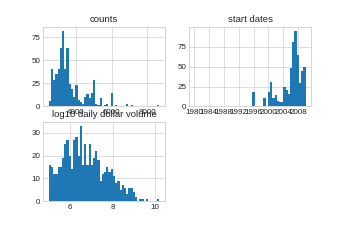

In [8]:
# identify the universe of ETFS
#############################################################
%nbagg
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )

hps = mx.HPSet(
    start = '20070101',    
    end='20200501',
    INTS_PER_DAY = 13,
    universe = mx.HPSet(
        start = '20100101',
        end='20200401',
        min_count=2000,
        min_dollar_vol=1e5
    )
)
etf_stats = etfd.compute_etf_stats()
etf_stats = etf_stats[etf_stats.vendor=='kibot']
orig_len = len( etf_stats )
# drop etfs without enough history
etf_stats = etf_stats[(etf_stats['start'] <= hps.universe.start ) 
                      & (etf_stats['end'] > hps.universe.end ) 
                      & (etf_stats['n'] >= hps.universe.min_count)
                      & (etf_stats['daily_dollar_volume_adj'] >= hps.universe.min_dollar_vol ) ]

disp( 'after filtering', len( etf_stats ), 'symbols out of original ' ,orig_len )

etf_stats = (etf_stats
             .merge( etfd.all_etfs, how='left', left_on='symbol', right_on='Symbol' )
             .drop( columns=['Symbol', 'ETP Name', 'Leveraged / Inverse' ])
             .rename( columns={'Asset Class':'asset_class', 'Description':'name'} )
             .fillna( 'Not Specified')             
             .set_index('symbol')
            )
disp( etf_stats.groupby('asset_class').name.count() )

ax = subplot( 2,2, 1 )
etf_stats.n.hist(ax=ax, bins=50)
ax.set_title( 'counts')

ax = subplot( 2,2, 2 )
etf_stats.start.hist(ax=ax, bins=50)
ax.set_title( 'start dates')

ax = subplot( 2,2, 3 )
etf_stats.daily_dollar_volume_adj.log10().hist(ax=ax, bins=50)
ax.set_title( 'log10 daily dollar volume')

# this is the universe we will work with. 
# HERO has a massive returns spike in 2015.11.09 - which throws off residualization quite a bit.
hps.universe.symbols = sorted( etf_stats.index.values )


In [9]:
# build up the data and features
#############################################
%inline
from research.etf_technical import etf_data_apr2020 as etfd; reload( etfd )
from research.etf_technical import etf_technical_20200517 as etfrc; reload( etfrc )

# fetch the data as a dataarray
builder = etfd.BuildDataWithAfacs( symbols=hps.universe.symbols, mkt_only=True, start=hps.start ,).set( memoize=True )
builder.data = None
disp( 'builder BuildDataWithAfacs_7f79ef4bf  expected got', builder.hash() )
da = builder(  )
df = builder.output_meta

# hyperparams related to computing returns and residuals
hps.returns_hps = mx.HPSet(    
    price_windows=[ 24*1, 24*5, 24*10],
    beta_halflifes=[13 * 90, 13 * 180, 13 * 252, 13*500],
    dollar_volume_window=13*180,
    ema_halflifes=[20 * 13, 60 * 13, 252 * 13],
    resid_halflife=13,
    
)
# compute log-returns, log-dollar-volume, betas, residual returns and clean up the data
rtn_computer = etfrc.compute_returns_and_betas( 
    start=hps.start, end=None,     
    dollar_volume_window=hps.returns_hps.dollar_volume_window, 
    price_windows = hps.returns_hps.price_windows,
    beta_halflifes=hps.returns_hps.beta_halflifes, 
    resid_halflife=None,    
) 
rtn_computer.data = builder
disp( 'expected compute_returns_and_betas_9280a30dd got', rtn_computer.hash(), h=4, color='teal' )

# add relative price and relative volume features
rel_price_and_vols = etfrc.add_relative_price_and_volumes( emas=hps.returns_hps.ema_halflifes )
rel_price_and_vols.data = rtn_computer
disp( 'expected add_relative_price_and_volumes_a65da371a got', rel_price_and_vols.hash(), h=4, color='teal' )

# add volatility and calendar features
add_vols = etfrc.add_volatilities( emas=hps.returns_hps.ema_halflifes )
add_vols.data = rel_price_and_vols
disp( 'expected add_volatilities_77ca914f0 got', add_vols.hash(), h=4, color='teal' )

da = add_vols(  )

In [10]:
# the features built up to now
############################################

hps.feature_set = mx.HPSet(
    unadj_prices=[
        'open_unadj_30min', 'high_unadj_30min', 'low_unadj_30min', 'close_unadj_30min', 'mid_unadj_30min',
        'log_open_unadj_30min', 'log_close_unadj_30min',
    ],
    adj_prices=[
        'open_adj_30min', 'high_adj_30min', 'low_adj_30min', 'close_adj_30min',
        'mid_adj_30min', 'mid_adj_0D.12h.vwap', 'mid_adj_2D.12h.vwap', 'mid_adj_5D.vwap',
        'open_adj_0D.12h', 'high_adj_0D.12h', 'low_adj_0D.12h',
        'open_adj_2D.12h', 'high_adj_2D.12h', 'low_adj_2D.12h',
        'open_adj_5D', 'high_adj_5D', 'low_adj_5D',
    ],
    rel_prices=[
        'rel_price_260', 'rel_price_780', 'rel_price_3276',
    ],
    volumes=[
        'volume_unadj_30min', 'dollar_volume_unadj_30min', 'avg_dollar_volume',
    ],
    log_volumes=[
        'log10_dollar_volume_30min', 'log10_dollar_volume_30min_resid',
    ],
    rel_volume=[
        'rel_dollar_volume_260', 'rel_dollar_volume_780',
        'rel_dollar_volume_3276',
    ],
    calendar=[
        'timeofday', 'cos1_timeofday', 'cos2_timeofday', 'cos4_timeofday',
        'dayofweek', 'cos1_dayofweek', 'cos2_dayofweek',
        'weekofmonth', 'cos1_weekofmonth', 'cos2_weekofmonth',
        'monthofquarter', 'cos1_monthofquarter', 'cos2_monthofquarter',
        'quarterofyear', 'cos1_quarterofyear', 'cos2_quarterofyear',
    ],
    lagging=[
        'lagrtn_adj_30min', 'lagrtn_adj_1hr', 'lagrtn_adj_1day',
        'lagrtn_adj_30min_resid',
    ],
    mkt=[
        'mkt_lagrtn_30min',
        'mkt_lagrtn_30min_260.rw_sd', 'mkt_lagrtn_30min_780.rw_sd', 'mkt_lagrtn_30min_3276.rw_sd',
    ],
    vol=[
        'lagrtn_adj_30min_260.rw_sd', 'lagrtn_adj_30min_780.rw_sd', 'lagrtn_adj_30min_3276.rw_sd',
        'lagrtn_adj_30min_resid_260.rw_sd', 'lagrtn_adj_30min_resid_780.rw_sd', 'lagrtn_adj_30min_resid_3276.rw_sd',
    ],
    zscores=[
        'lagrtn_adj_30min_260.rw_zscore', 'lagrtn_adj_30min_780.rw_zscore', 'lagrtn_adj_30min_3276.rw_zscore',
        'lagrtn_adj_30min_resid_260.rw_zscore', 'lagrtn_adj_30min_resid_780.rw_zscore',
        'lagrtn_adj_30min_resid_3276.rw_zscore',
    ],
    betas=[
        'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min_2340.ew_beta',
        'lagrtn_adj_30min_3276.ew_beta', 'lagrtn_adj_30min_6500.ew_beta',
    ],
    afacs=[ 'bw_afac_30min', 'fw_afac_30min' ],
    technical=[
        'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
        'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
        'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
        'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
        'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
    ],    
)
hps.leading_rtns = [
    'leadrtn_adj_30min', 'leadrtn_adj_1hr', 'leadrtn_adj_1day',
    'mkt_leadrtn_30min', 'mkt_leadrtn_1day',
]
hps.weights = ['valid_30min', 'weight', ]

In [11]:
##### Profile the various sub-feature sets computed (don't run this too often )
##############################################################################
%inline
@mx.operatorize( memoize=True, produces_features=False )
def FeatureCorrelations( data, features, start, frac=0.5 ):
    '''computer feature set correlations'''
    data = data.loc[start:, :, features]
    if frac:
        ix = pd.Series( range( len( data ) ) ).sample( frac=frac, random_state=1 )
        data = data[ix.values]
    return data.corr_mx()

def process_one_feature_set( data, fs_features=None, leading=hps.leading_rtns ):
    '''profile one feature set '''
    with mx.timer( 'computing feautre coorelations' ):
        fc = FeatureCorrelations( start=None )
        fc.data = data
        fc.features = fs_features + leading
        corr_df = fc()
    with mx.timer( 'running profile' ):
        #  -- profile the features
        profiler = mx.FeatureProfiler(
            returns=['leadrtn_adj_30min', 'leadrtn_adj_1day',],
            exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'mkt_lagrtn_30min'],
            transforms=None, weight='weight', winsorize=0.05, xs=None, start=None,
            lags=[1, 3, 5], autocorr=[1, 2, 13]
        ).set( verbose=False, memoize=True )
        profiler.data = data
        profiler.features = fs_features
        profiler.run()
    return corr_df, profiler

# for fs in ['statfac', 'technical', 'afacs', 'betas' ]: #+ list( hps.feature_set.keys() ):    
#     fs_features = getattr( hps.feature_set, fs )
#     disp( 'processing ', fs_features, h=2 )
#     corr_df, profiler = process_one_feature_set( fs_features=fs_features ) 
#     mx.disp( corr_df.loc[fs_features], corr=True )    
#     profiler.display()     

## define the online runner operator

In [12]:
# define the onlinerunner operator
####################
mx.online = mx.online.reload()

@mx.operatorize( memoize=True, consumes_features=False, produces_features=True, produces_meta=True )
def OnlineRunner( da, hps, tensorboard=True, verbose=True ):
    ''' run one configuration end to end''' 
    logger = mx.Logger( 'OnlineRunner' )
    da_use = da.loc[hps.start:hps.end]
    # make sure you don't squeeze out this dimension !
    if hps.symbol:
        da_use = da_use.sel( symbol=mx.make_iterable(hps.symbol ) )            
    features = list( hps.features )
    output_features = []

    # this round about shit is because cloudpickl in the memoization fucks up nan checks in ema-updater
    if hps.transformer:
        tfs = []
        if hps.transformer.pre_normalize:
            tfs.append( mx.online.OnlineNorm( demean=True, normalize=True ) )
        if hps.transformer.quadratic:
            tfs.append( mx.online.OnlineFeatures( transform='quadratic')  )
        if hps.transformer.ema_halflifes:
            tfs.append( mx.online.OnlineEma( halflifes=hps.transformer.ema_halflifes ) )
        if hps.transformer.post_normalize:
            tfs.append( mx.online.OnlineNorm( demean=True, normalize=True ) )
        transformer = tr.nn.Sequential( *tfs )
    else:
        transformer = None

    if hps.pre_winsorize:
        with logger.timer( '# pre-winsorize teh input features'):
            wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=hps.pre_winsorize )
            da_use = wins( da_use, features=features )
            features = wins.output_features
        
    X = da_use.loc[:, :, features ]
    Y = da_use.loc[:, :, [hps.target]]
    # advance the target  and add thsi to the lookahead
    if hps.target_shift:
        Y = Y.lag( -hps.target_shift )
        hps.lookahead += hps.target_shift
    W = da_use.loc[:, :, [hps.weight]]
    Z = da_use.loc[:,:, hps.ortho_features ]
    
    # demean X
    if hps.batch_demean:
        X = ( X - X.mean( dim=['time','symbol']) )
    if hps.batch_normalize:
        X = X / ( X.sq().mean( dim=['time','symbol']).sqrt() + 1e-13 )        
        
    for _ in range( 5 ):
        gc.collect(); tr.cuda.empty_cache()

    Xt = X.fillna(0).to_tensor( dtype=dtype, device=device )
    Yt = Y.fillna(0).to_tensor( dtype=dtype, device=device )
    Wt = W.fillna(0).to_tensor( dtype=dtype, device=device )
    Zt = Z.fillna(0).to_tensor( dtype=dtype, device=device )
    
    with logger.timer(" the linear rnn learner"):
        linear_rnn = mx.online.OnlineRNN(
            lookahead=hps.lookahead, ridge=hps.ridge, kappa=hps.kappa, algo=hps.algo, halflife_1=hps.hl_1, halflife_2=hps.hl_2,
            lr=hps.lr, tv=hps.rnn_tv, ortho=hps.ortho, use_omega=hps.use_omega, omega_lr=hps.omega_lr, omega_ridge=hps.omega_ridge,
            omega_shift=hps.omega_shift, halflife_ortho=hps.ortho_hl, transformer=transformer,            
        ) 
        linear_rnn.verbose = verbose 
        Yht, meta, state = linear_rnn( X=Xt, Y=Yt, W=Wt, Z=Zt, )    
        disp( 'runtimes for the online rnn', linear_rnn.profiles )
        del linear_rnn;    tr.cuda.empty_cache()        
        # convert resutls to dataarray
        output_feature = f'{hps.target}_hat'
        da_use = da_use.assign_features( **{output_feature: Yht.squeeze(-1).to_dataarray( Y.squeeze(axis=-1) )  } )
        output_features.append( output_feature )        

    # drop some initial data for online priming
    da_use = da_use[500:]
    del Xt, Yt, Wt, Zt, Yht;    
    for _ in range( 5 ):
        gc.collect(); tr.cuda.empty_cache()

    
    with logger.timer('  winsorizations'):
        wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=0.05 )
        da_use = wins( da_use, features=output_features )    
        output_features += wins.output_features

    with logger.timer( 'profiling ' ): 
        profiler = mx.FeatureProfiler(
            returns=['leadrtn_adj_30min', 'leadrtn_adj_1hr' ],
            exposures=hps.exposures,
            transforms=None, weight=hps.weight, winsorize=None, xs=None, 
            lags=[1, 2], autocorr=[1, 2, 13], remove_intercept=False,
        ).set(verbose=False, memoize=False)
        profiler.data = da_use
        profiler.features = output_features
        profiler.run()
    
    return da_use, output_features,  profiler.output_meta

## baseline online model - 1 with long learning rate

/home/fj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


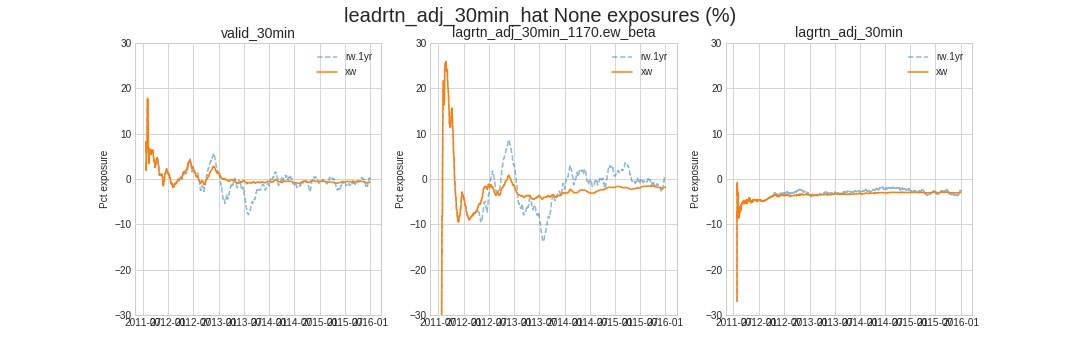

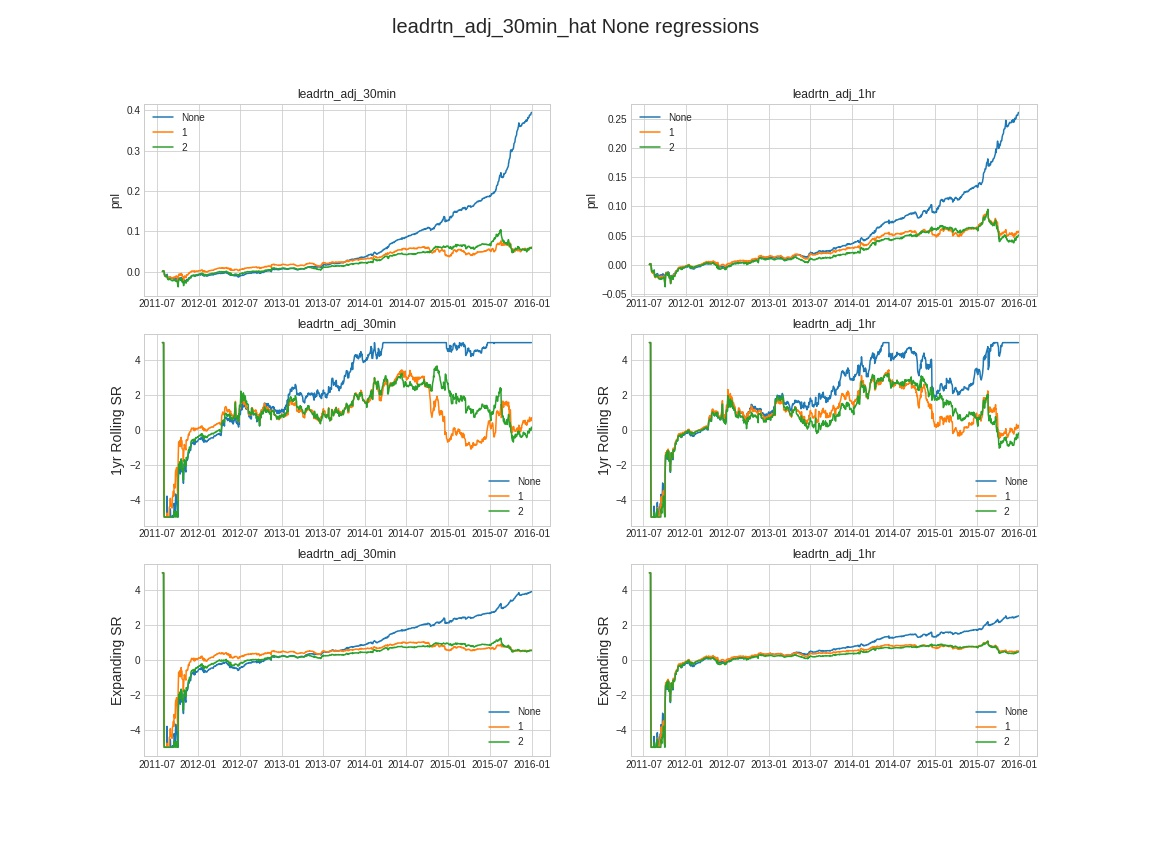

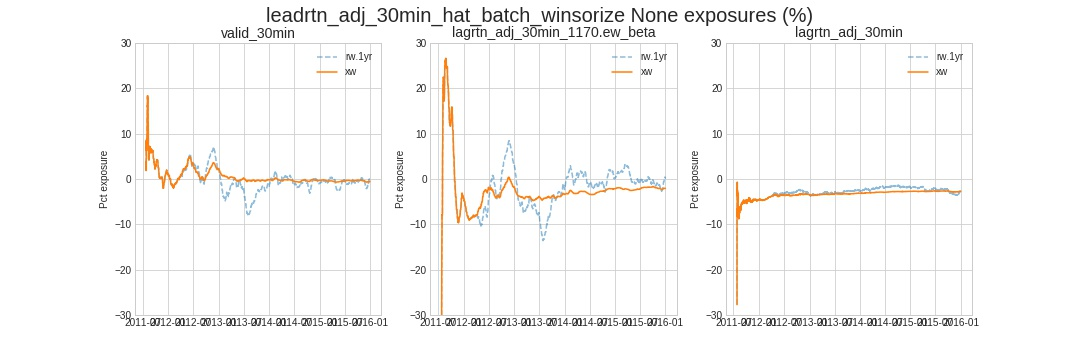

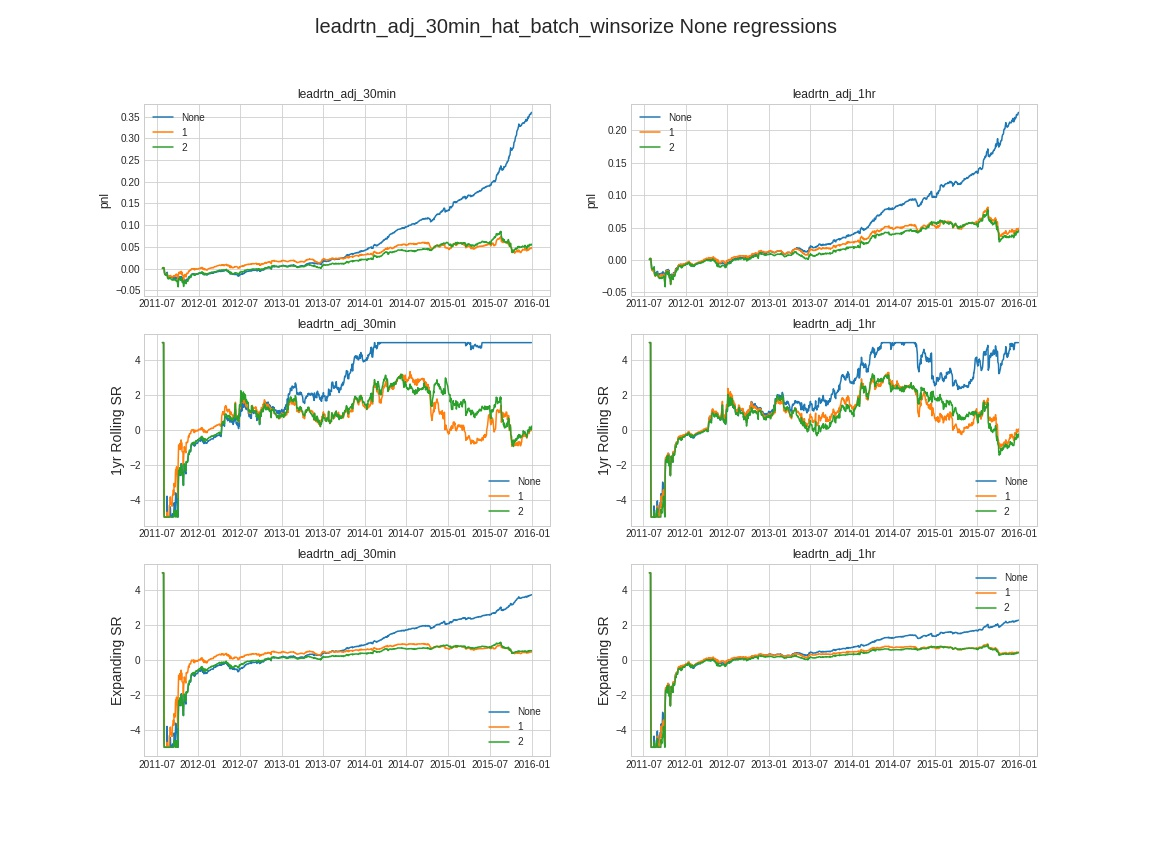

In [17]:
# baseling online learning model with long halflife
##############################################
%inline
mx.online = mx.online.reload()

data = add_vols

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20110601', #hps.start,
    end='20160101', #hps.end
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
#         + hps.feature_set.vol 
#         + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
#         + hps.feature_set.betas
        + hps.feature_set.technical
#          + hps.feature_set.afacs
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = 50,
    hl_2 = 1000,
    lr = 100,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox', 
    # stuff related to sid weighting
    use_omega=None,
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

## baseline online model - long hl_2 with gd

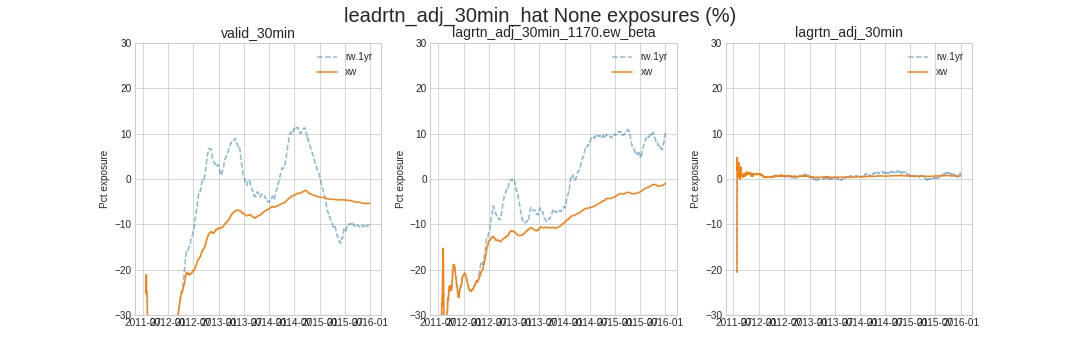

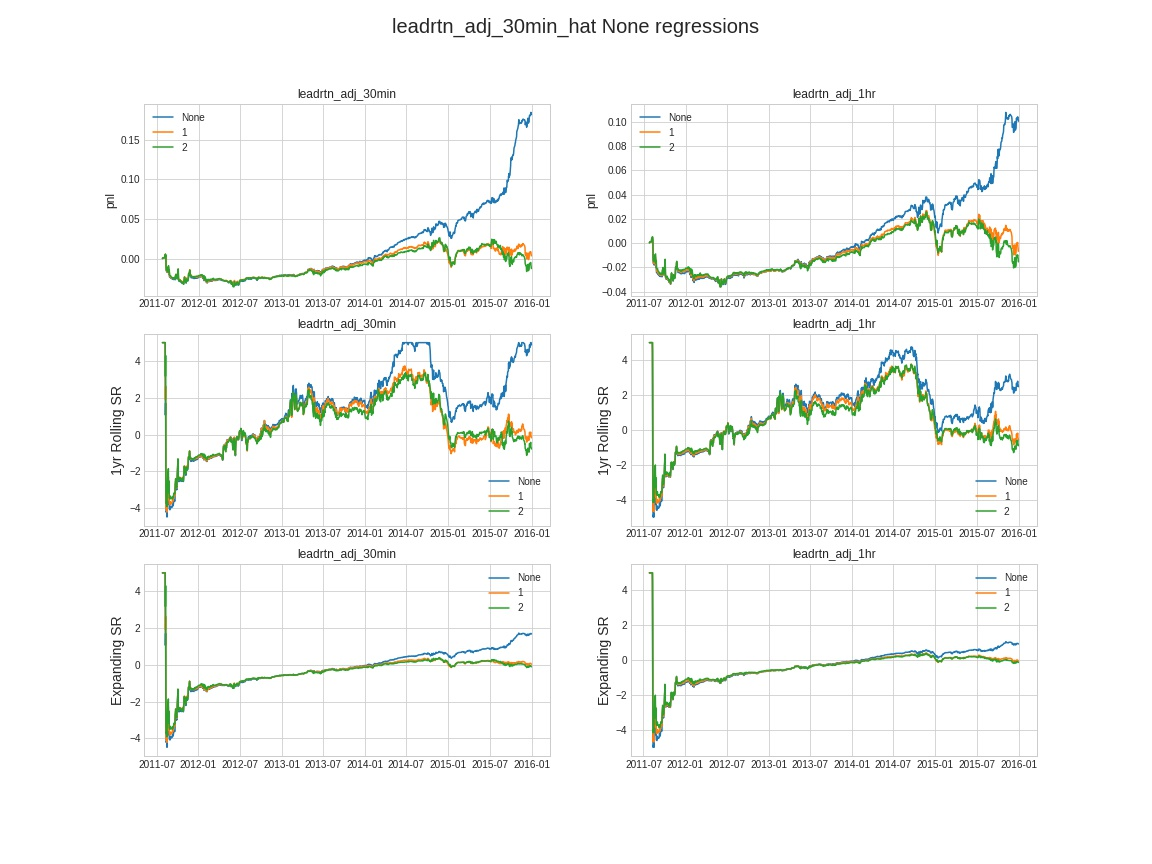

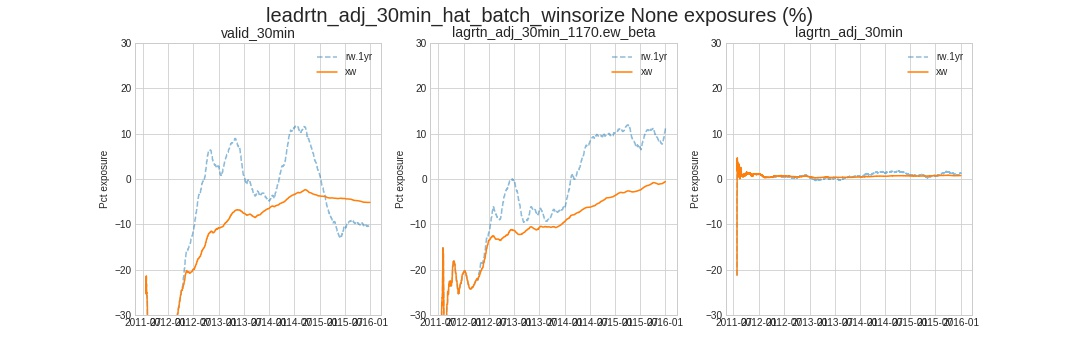

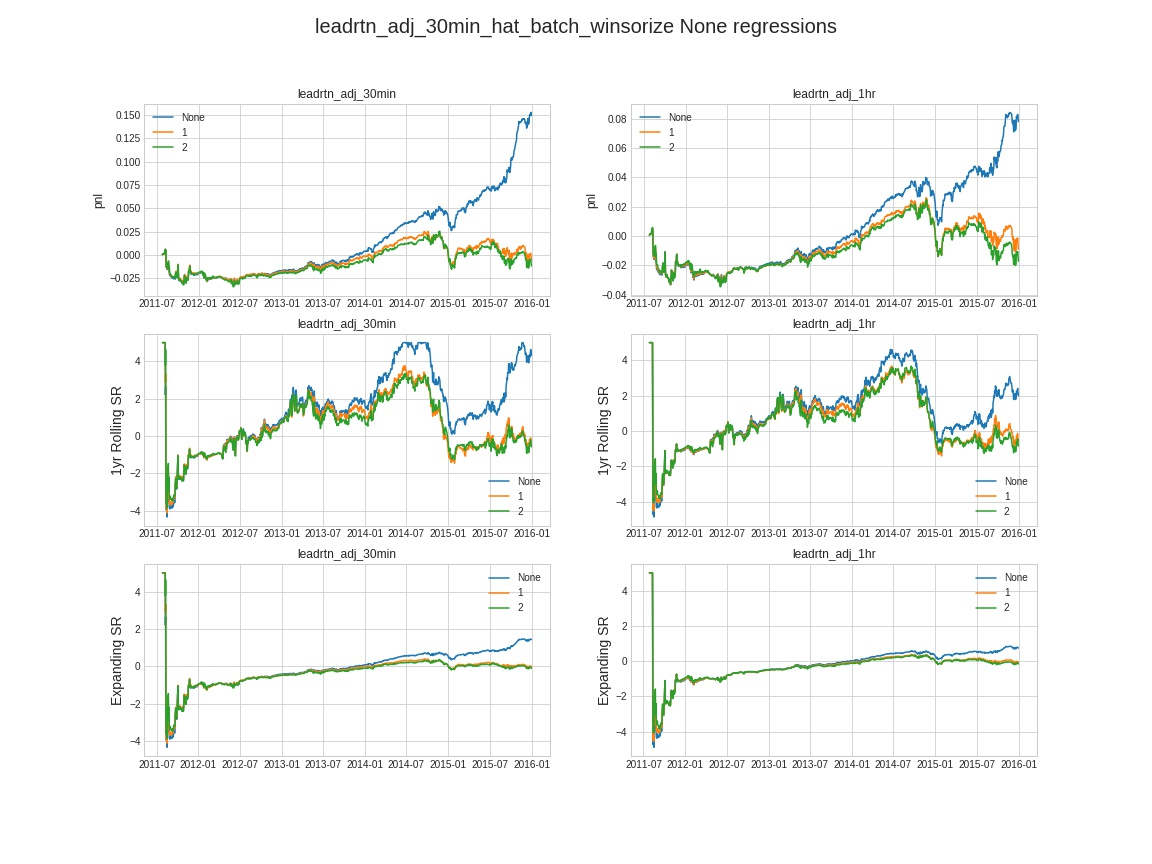

In [24]:
# baseling online learning model with long halflife and gd
##############################################
%inline
mx.online = mx.online.reload()

data = add_vols

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20110601', #hps.start,
    end='20160101', #hps.end
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
#         + hps.feature_set.vol 
#         + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
#         + hps.feature_set.betas
        + hps.feature_set.technical
#          + hps.feature_set.afacs
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = 50,
    hl_2 = 1000,
    lr = 1e-7    ,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='gd', 
    # stuff related to sid weighting
    use_omega=None,
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

## baseline online model - short hl_2 with gd

/home/fj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


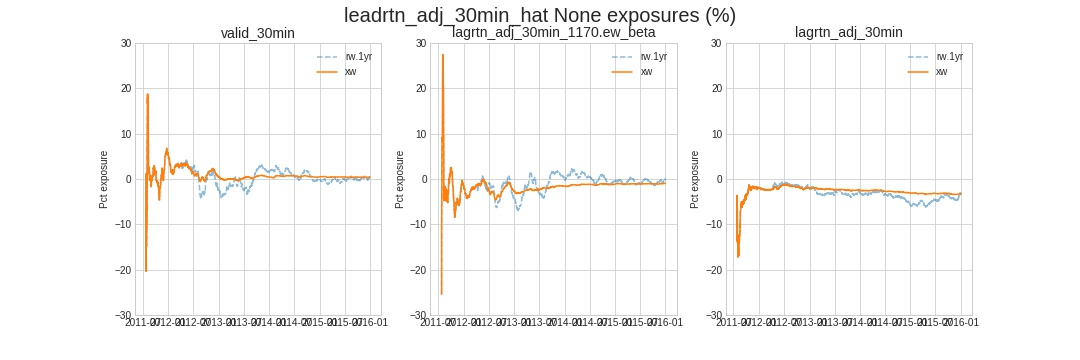

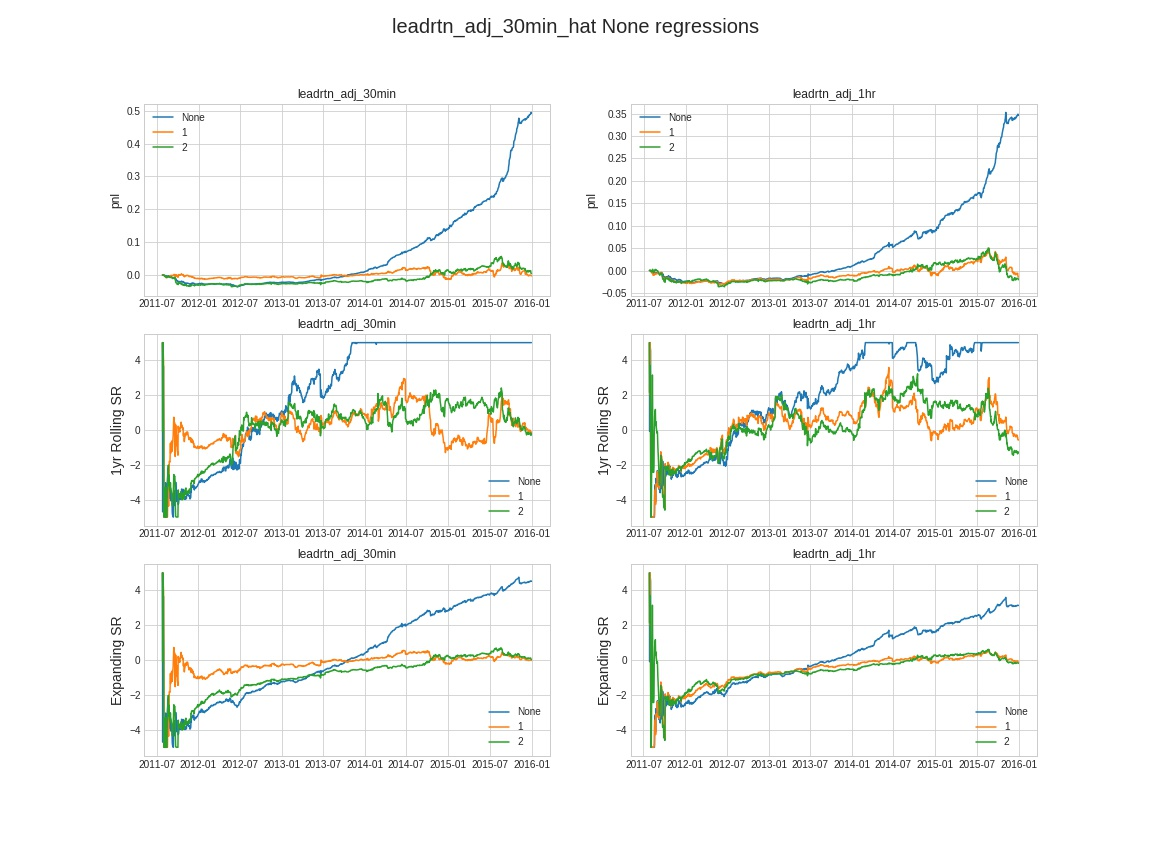

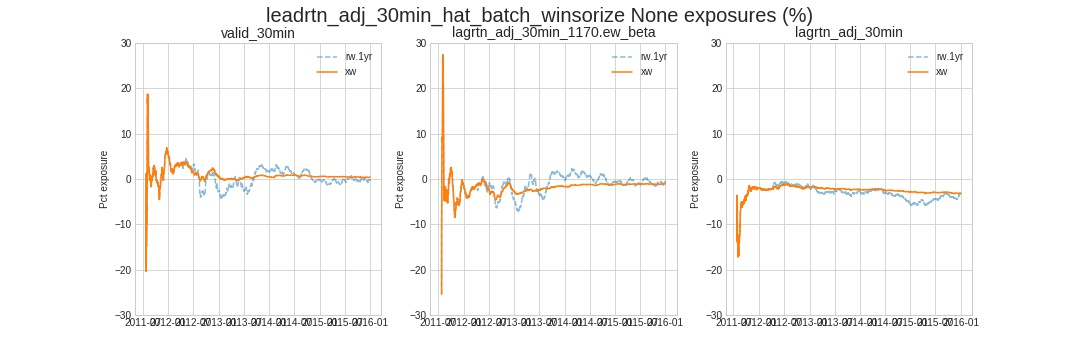

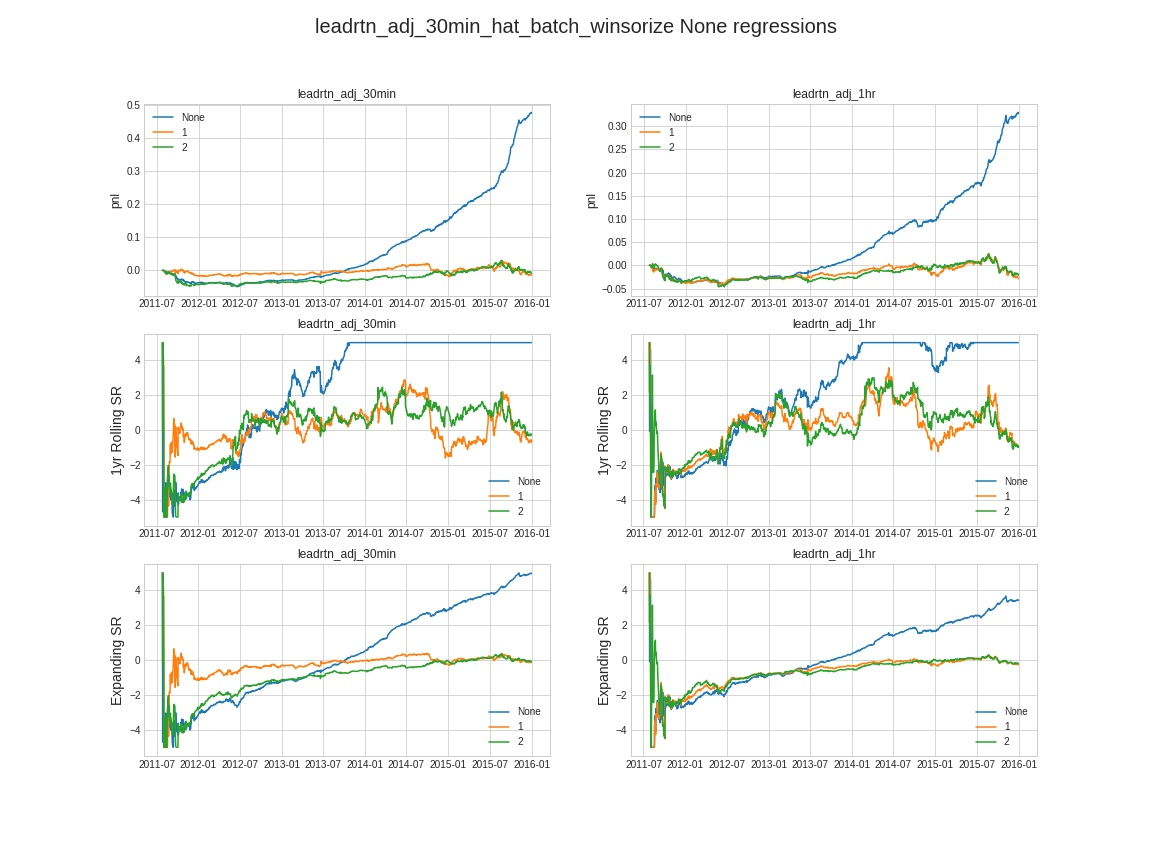

In [31]:
# baseling online learning model with short halflifes and direct solve
##############################################
%inline
mx = mx.reload()
mxtr = mxtr.reload()
mx.online = mx.online.reload()
mx.Config.start()

data = add_vols

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20110601', #hps.start,
    end='20160101', #hps.end
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
#         + hps.feature_set.vol 
#         + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
#         + hps.feature_set.betas
        + hps.feature_set.technical
#          + hps.feature_set.afacs
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = 50,
    hl_2 = 50,
    lr = 100,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox', 
    # stuff related to sid weighting
    use_omega='P',
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=None ), #[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

# baseling online learning model with no hl_1 or hl_2

/home/fj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


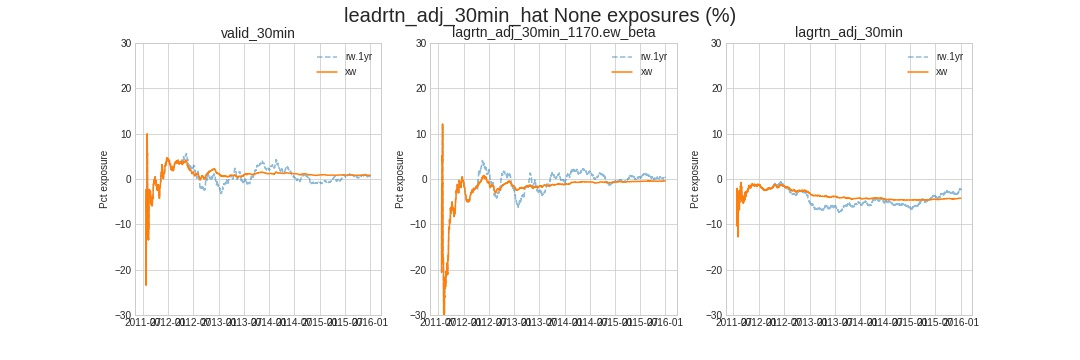

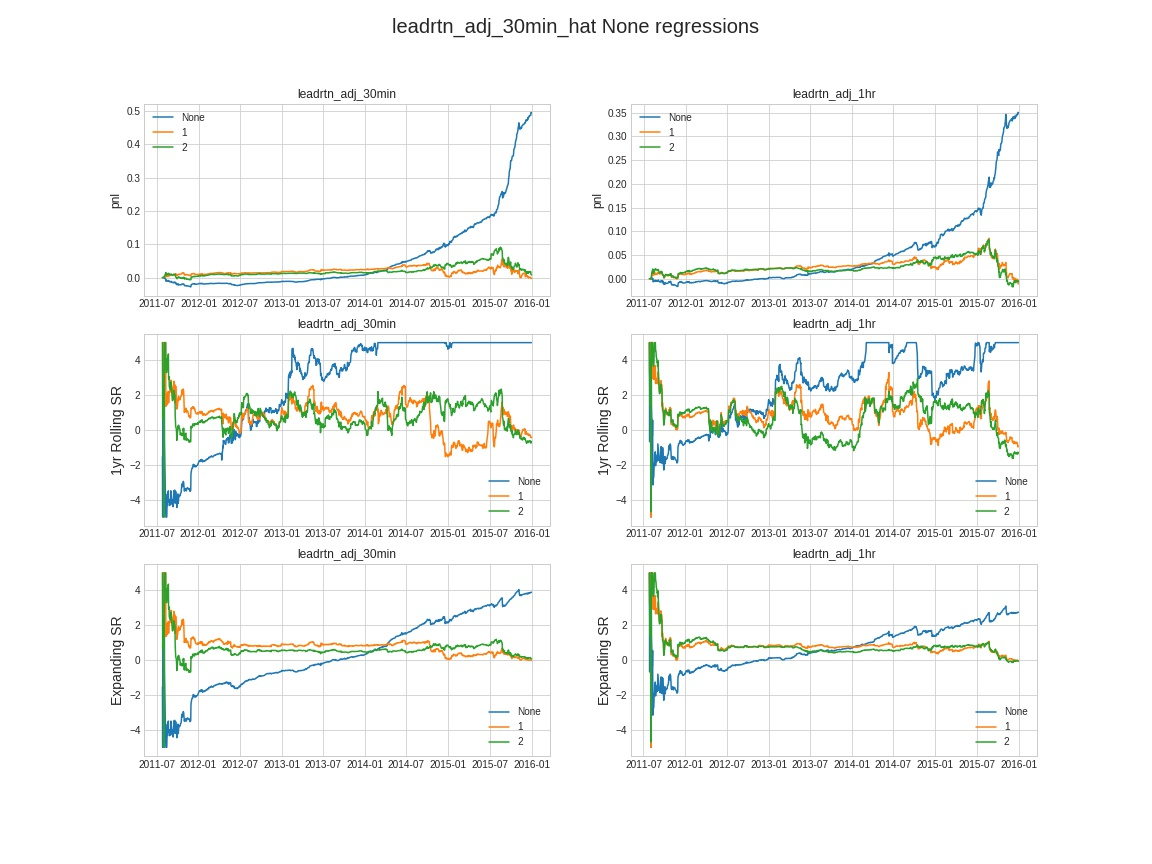

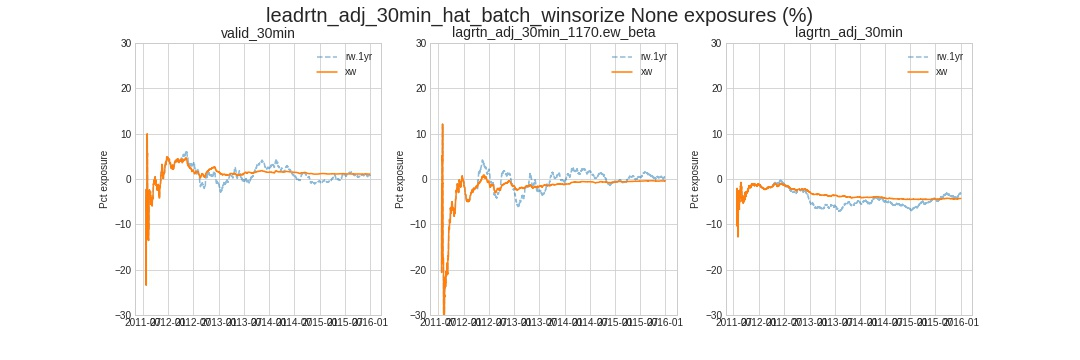

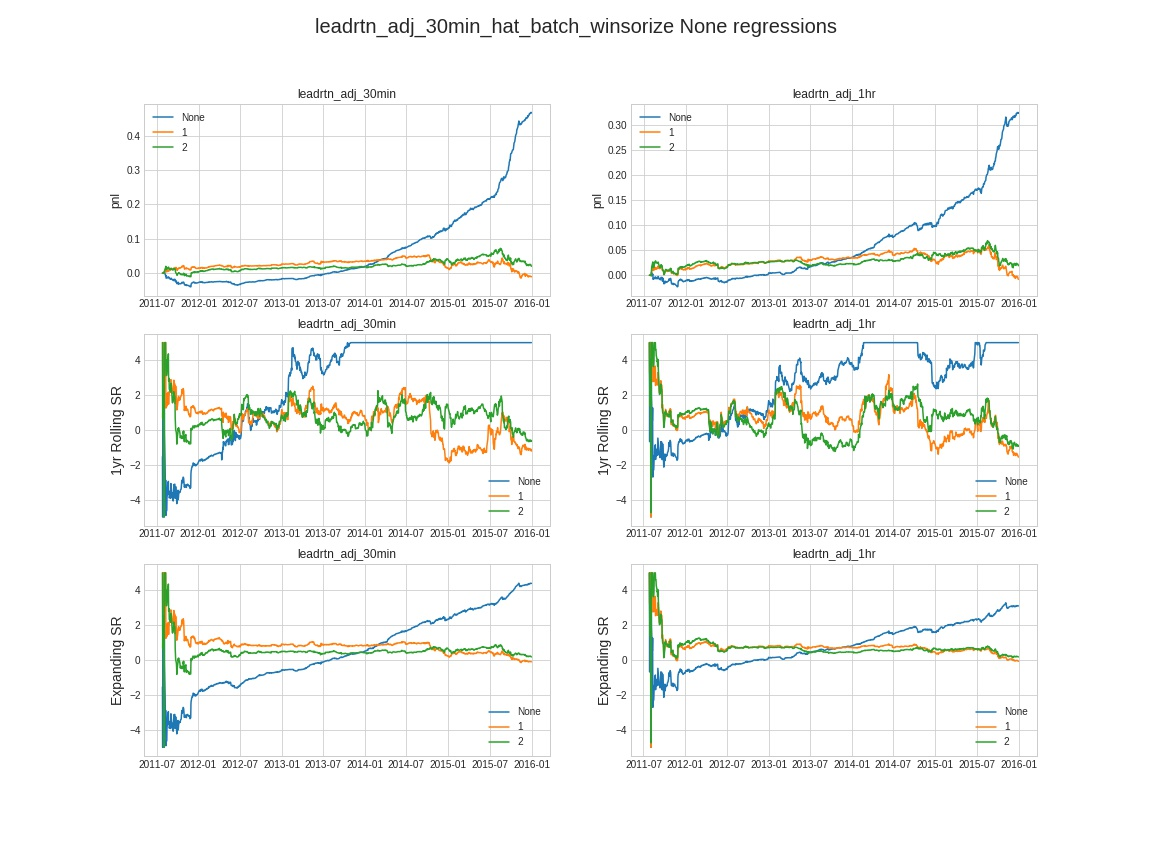

In [11]:
# baseling online learning model with no hl_2
##############################################
%inline
data = add_vols

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20110601', #hps.start,
    end='20160101', #hps.end
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
#         + hps.feature_set.vol 
#         + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
#         + hps.feature_set.betas
        + hps.feature_set.technical
#          + hps.feature_set.afacs
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = None,
    hl_2 = None,
    lr = 500,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox', 
    # stuff related to sid weighting
    use_omega='P',
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=None ), #[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

# online learning with no hl_1 or hl_2 and no technical features


/home/fj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


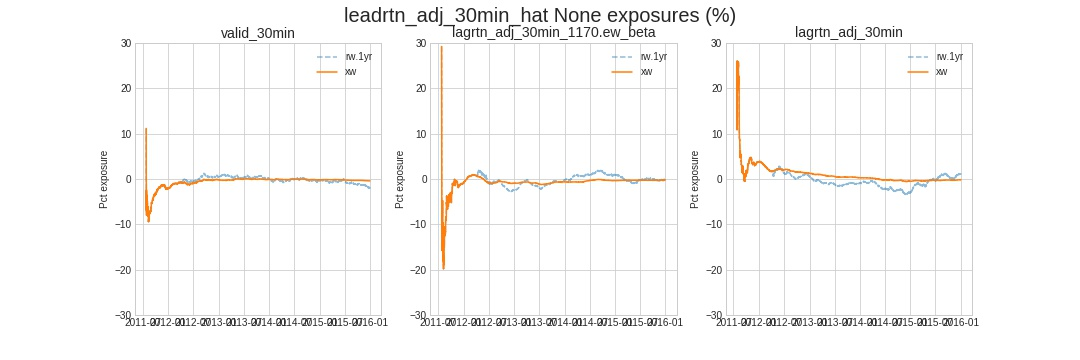

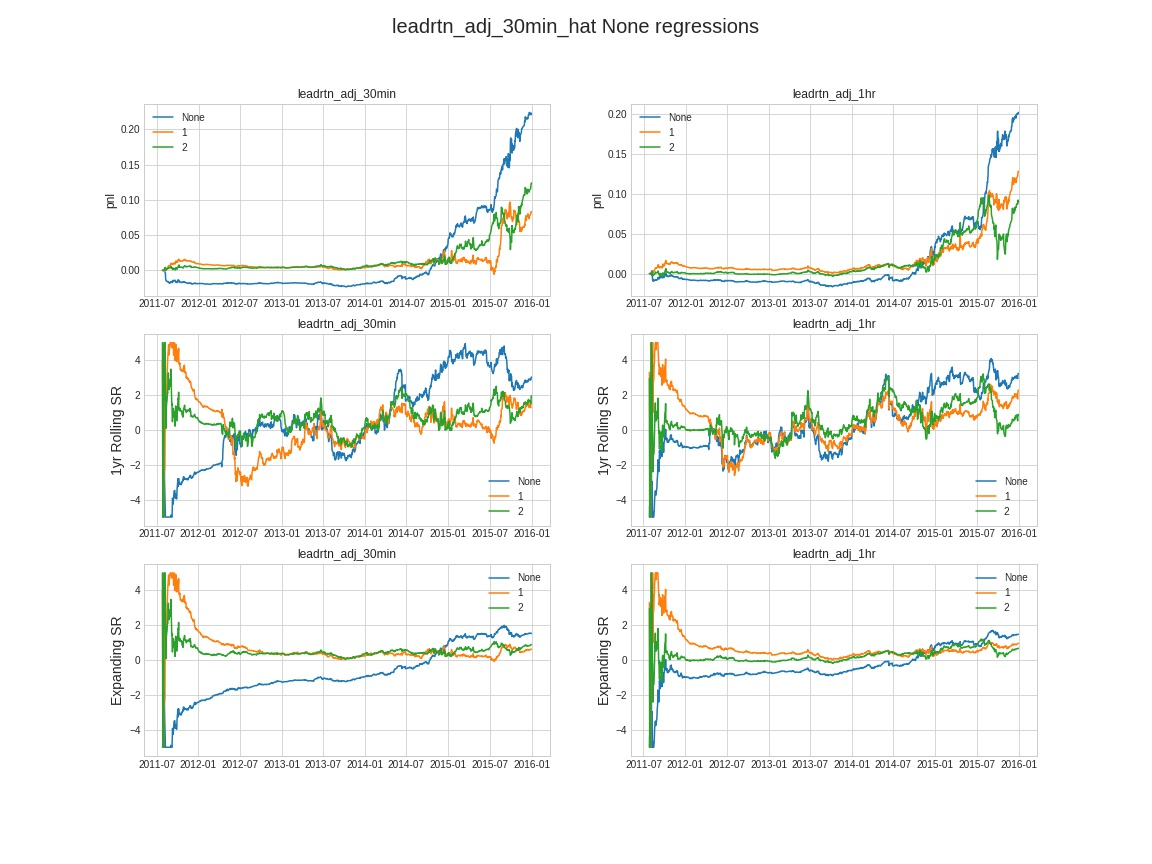

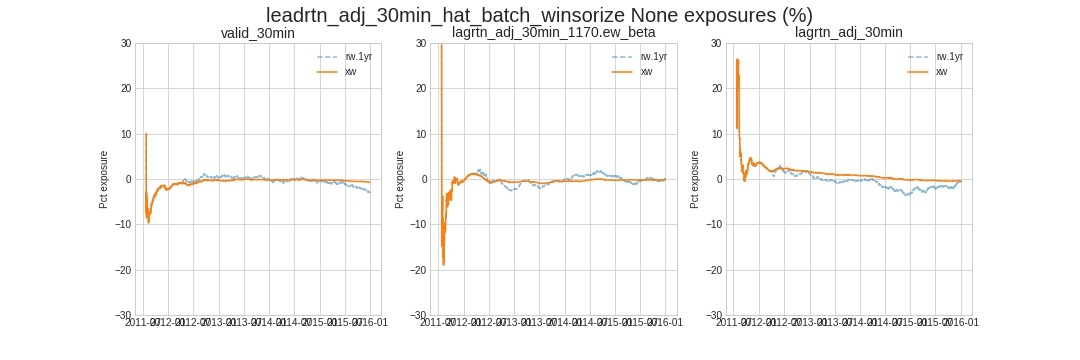

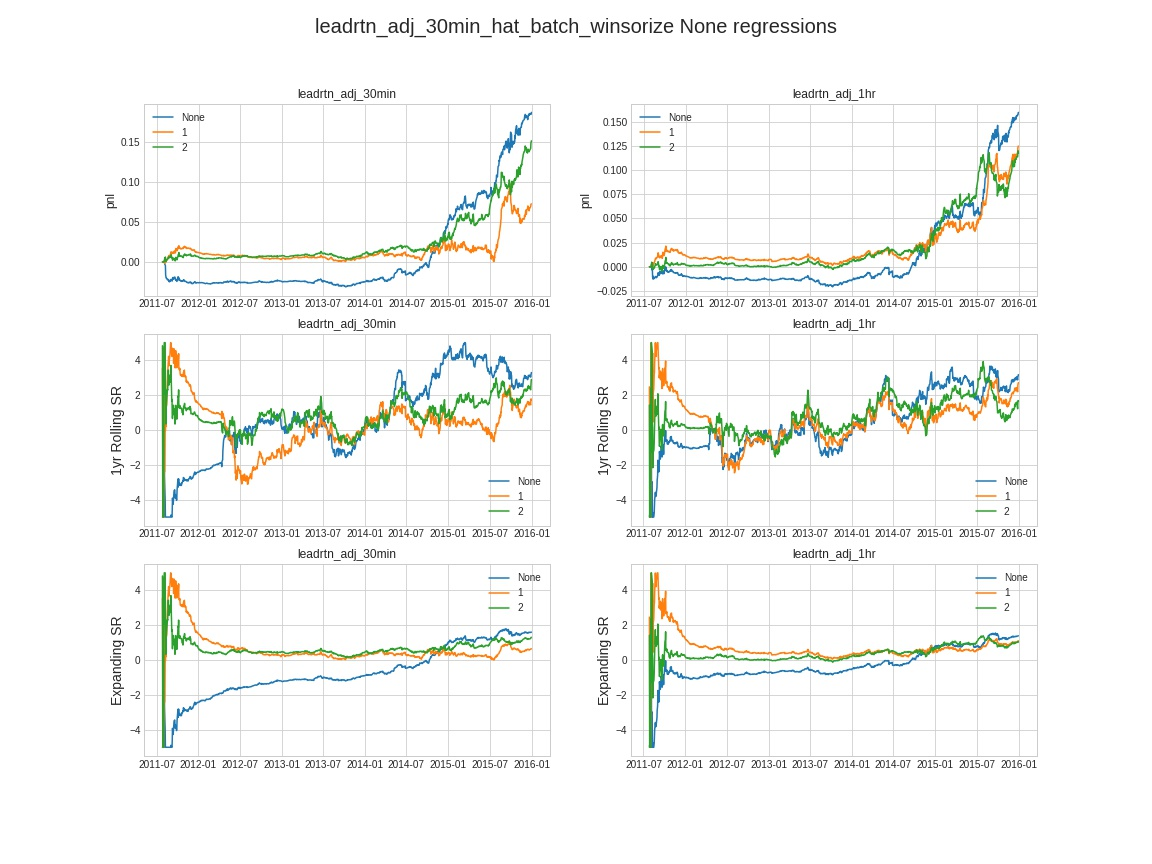

In [13]:
# online learning with no hl1 and no technical features
########################################


%inline
data = add_vols

technical_features=[
    'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
    'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
    #'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
    'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
    'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
]

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20110601', #hps.start,
    end='20160101', #hps.end
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
        + hps.feature_set.vol 
#        + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
        + hps.feature_set.betas
#          + hps.feature_set.technical
#          + hps.feature_set.afacs
#        + technical_features
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = None,
    hl_2 = None,
    lr = 500,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox', 
    # stuff related to sid weighting
    use_omega='P',
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=None ), #[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

    

## subset of technical featuers

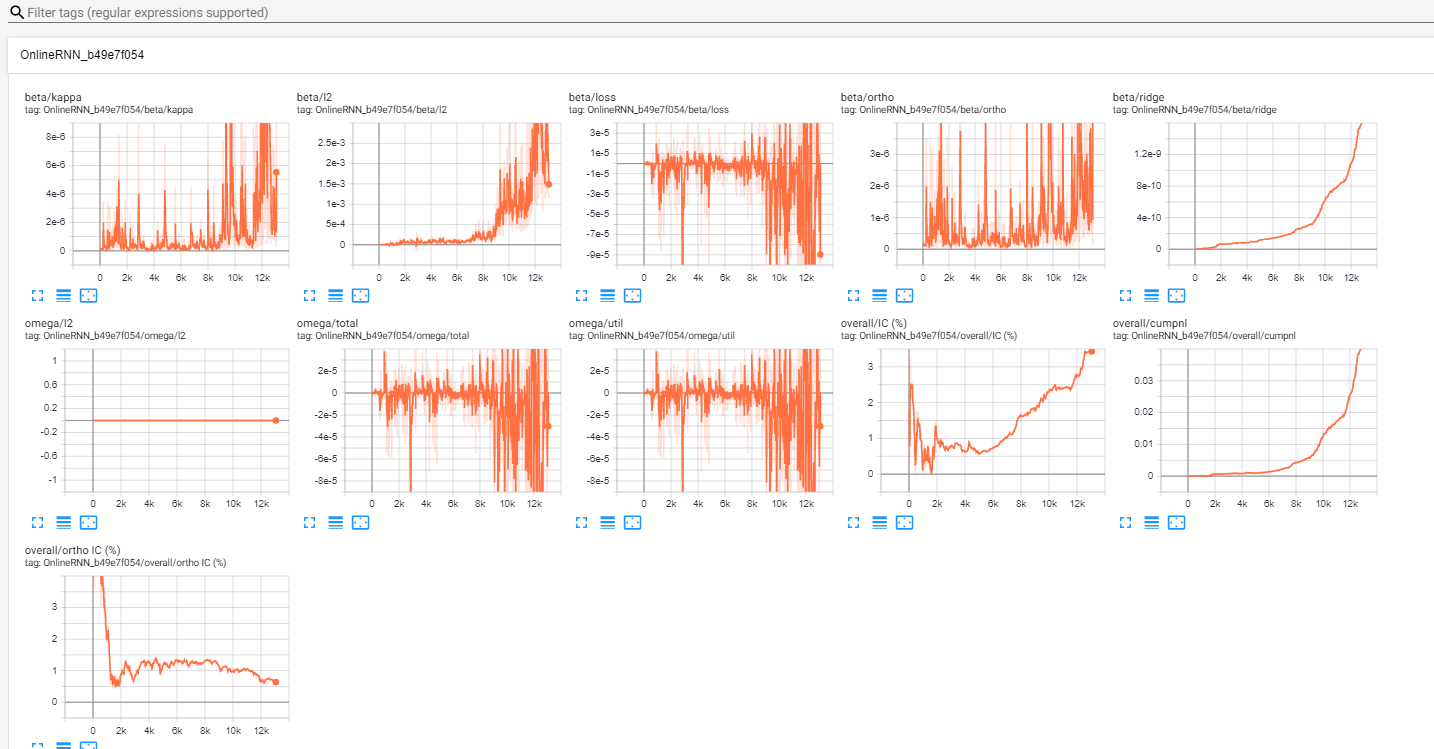

/home/fj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


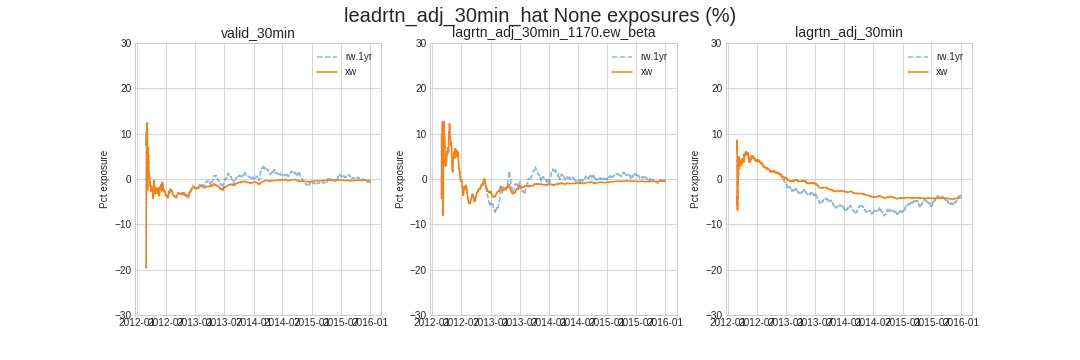

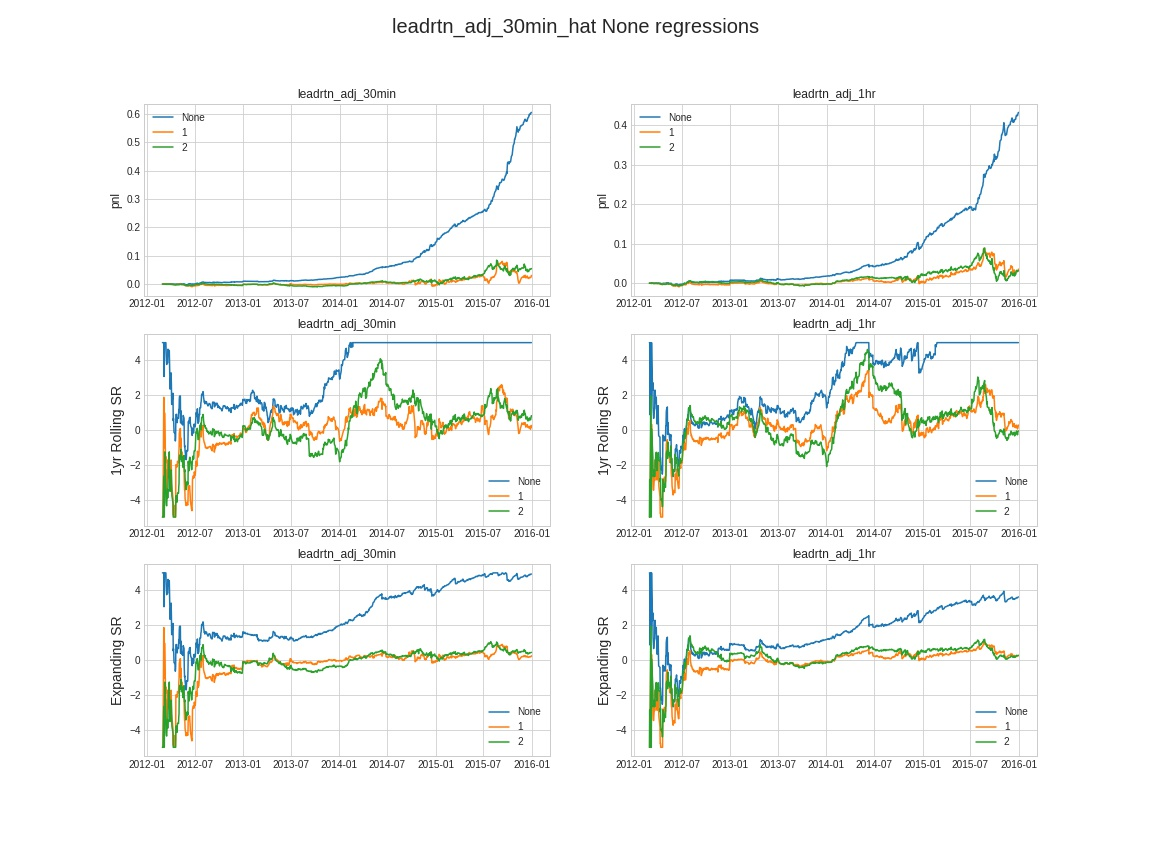

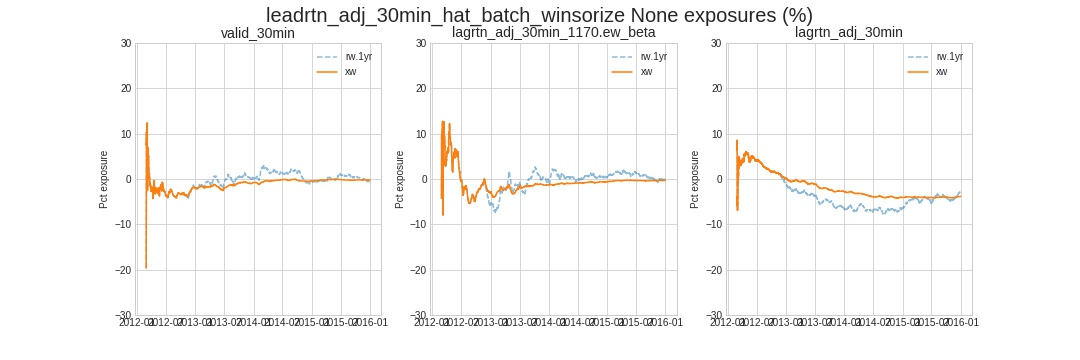

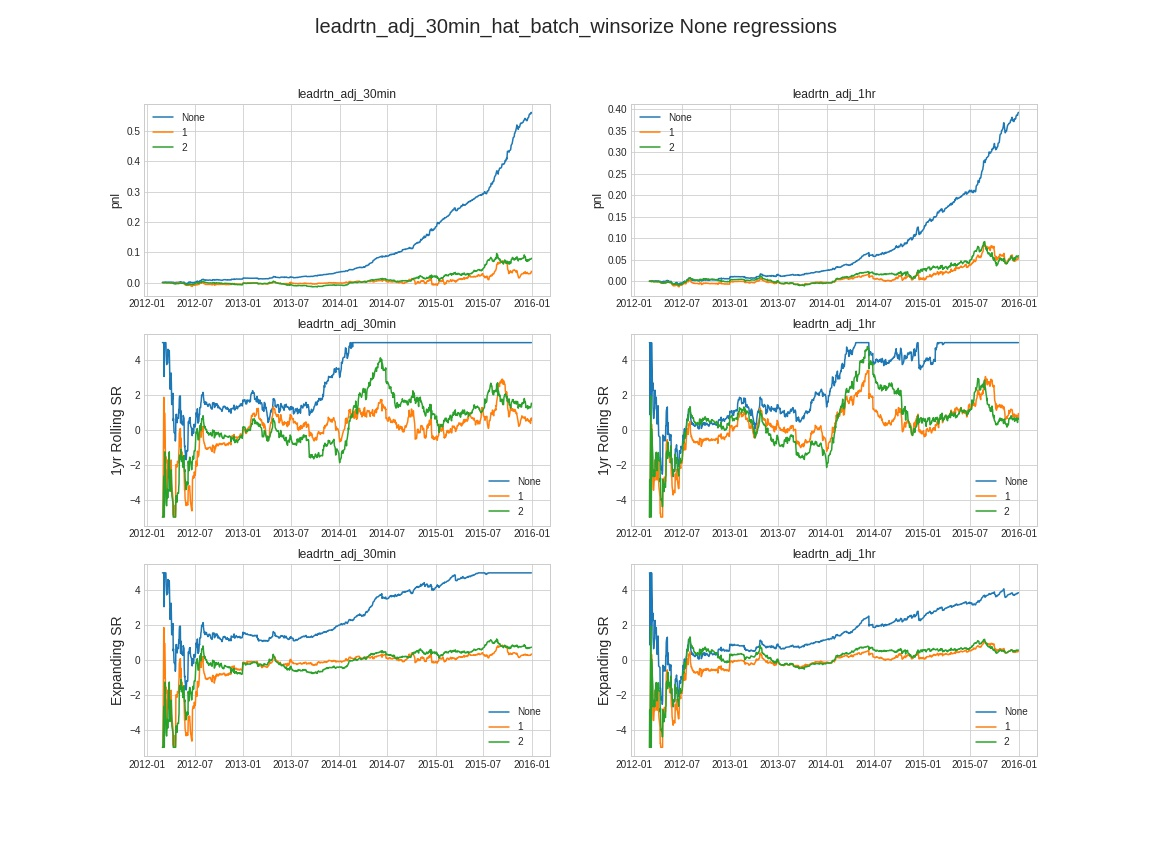

In [7]:
# online learning
#################

%inline
data = add_vols

technical_features=[
    'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
    'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
    #'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
    'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
    'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
]

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20120101',
    end='20160101', #hps.end
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
        + hps.feature_set.vol 
        + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
        + hps.feature_set.betas
#          + hps.feature_set.technical
#          + hps.feature_set.afacs
        + technical_features
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = None,
    hl_2 = None,
    lr = 500,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox', 
    # stuff related to sid weighting
    use_omega='P',
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=None ), #[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

    

## Extended time range for the above

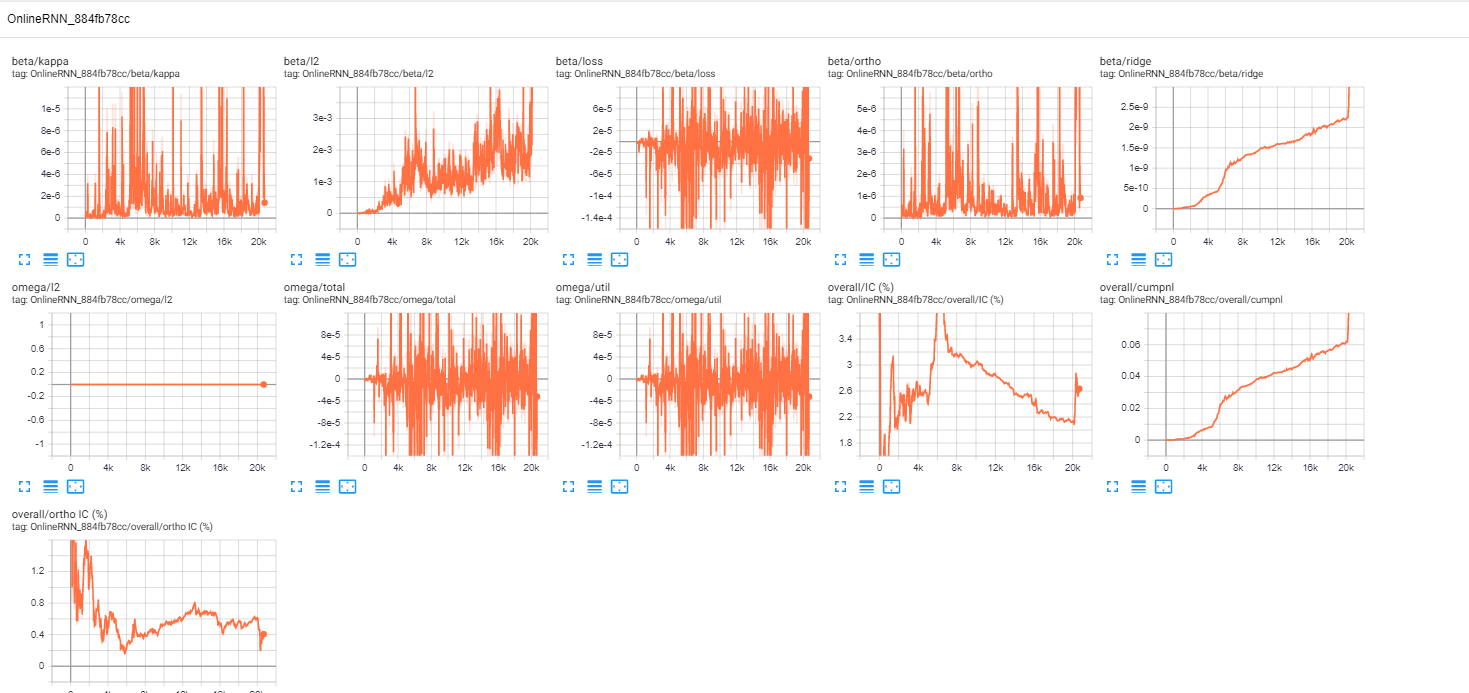

In [ ]:
# online learning
#################

%inline
data = add_vols

technical_features=[
    'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
    'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
    #'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
    'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
    'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
]

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20140101',
    end=hps.end,
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
        + hps.feature_set.vol 
        + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
        + hps.feature_set.betas
#          + hps.feature_set.technical
#          + hps.feature_set.afacs
        + technical_features
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = None,
    hl_2 = None,
    lr = 500,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox', 
    # stuff related to sid weighting
    use_omega='P',
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=None ), #[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

    

## subset of technical features with ema halflifes

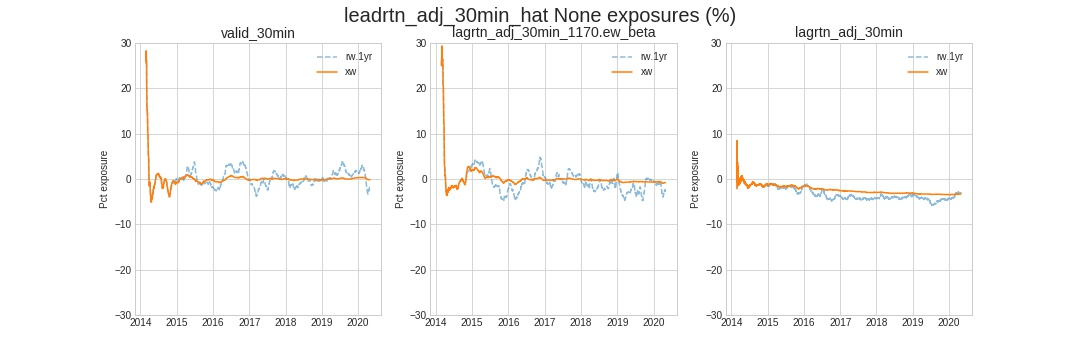

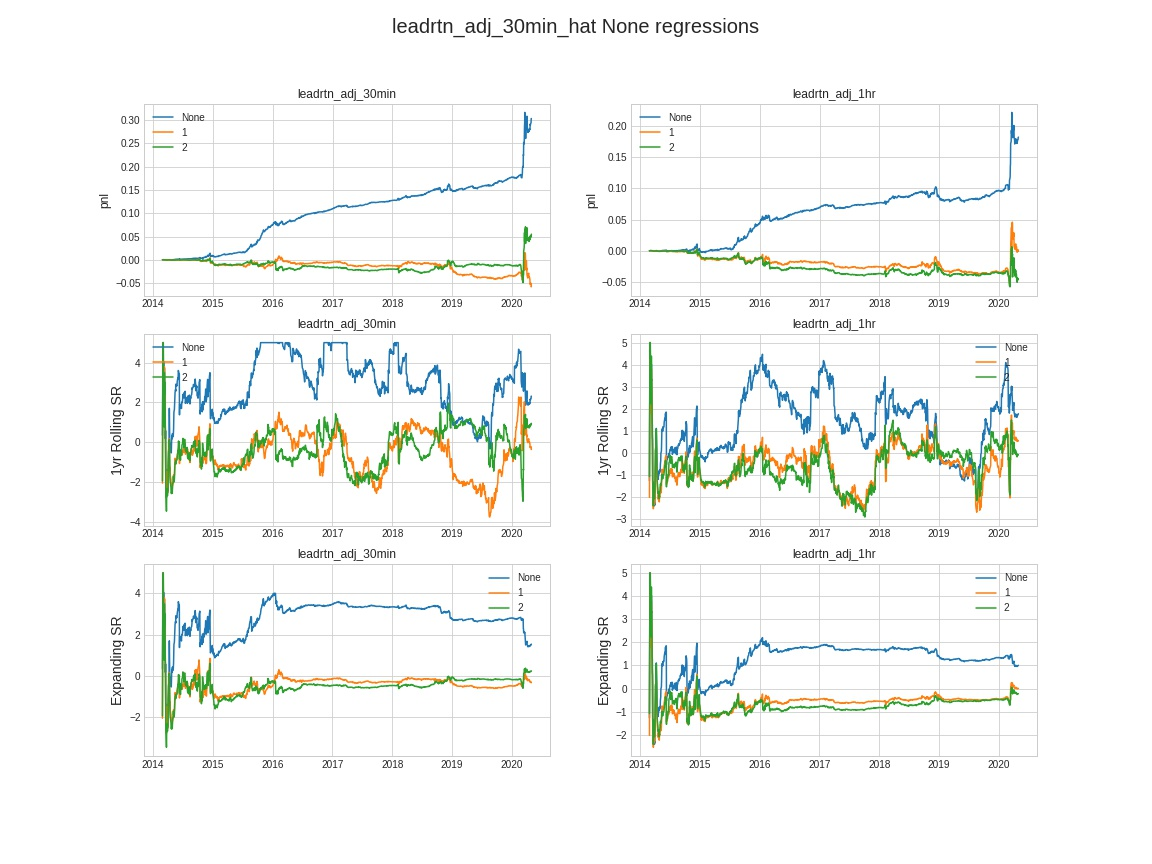

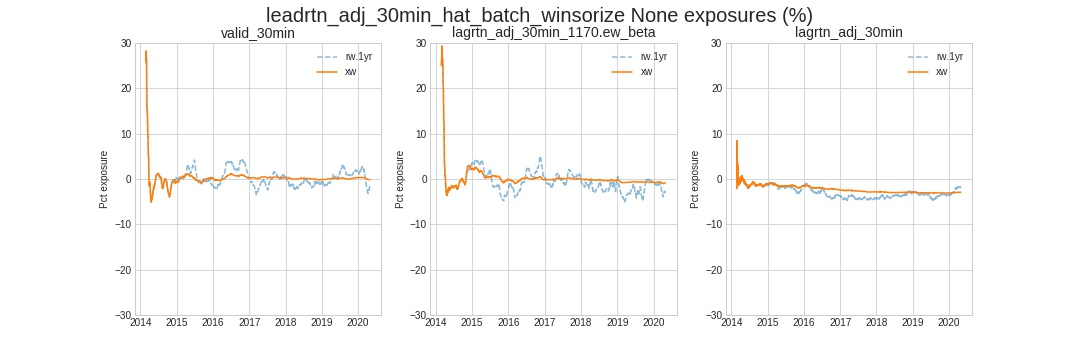

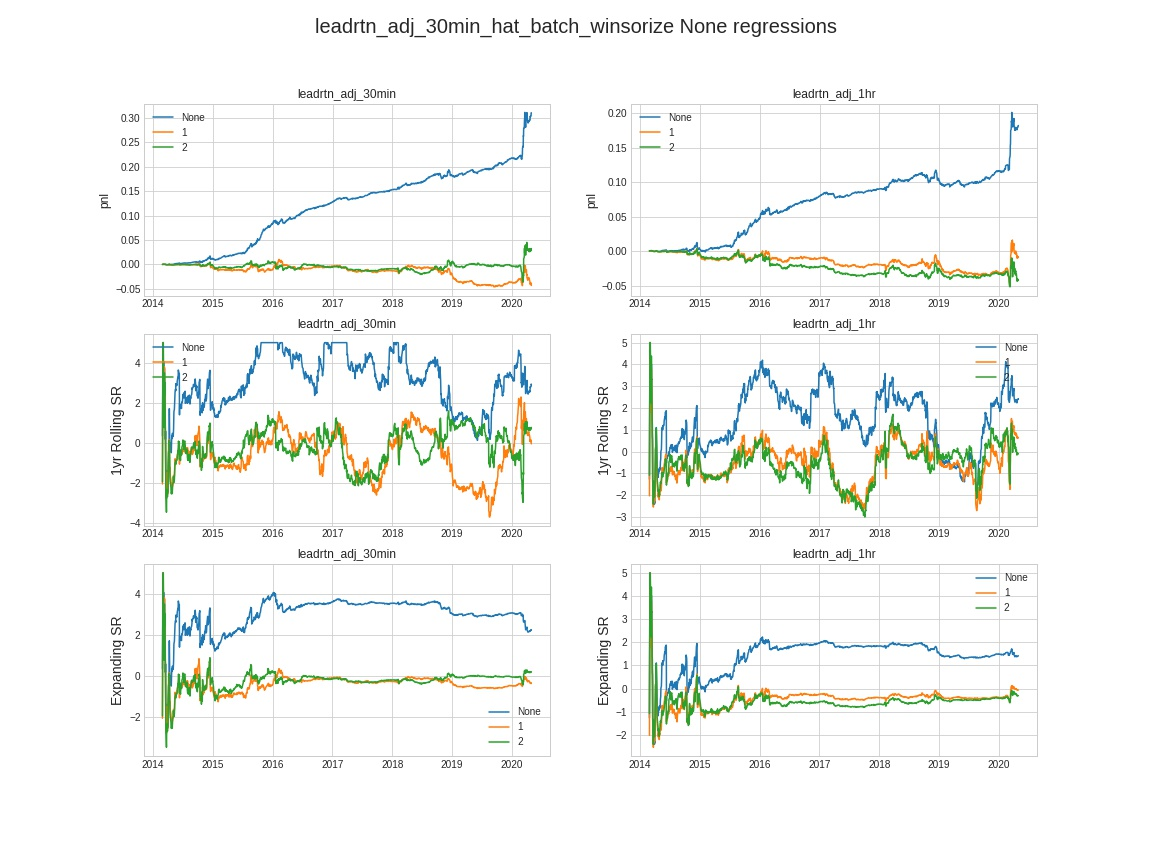

In [7]:
# online learning
#################

%inline
data = add_vols

technical_features=[
    'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
    'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
    #'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
    'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
    'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
]

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20140101',
    end=hps.end,
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
        + hps.feature_set.vol 
        + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
        + hps.feature_set.betas
#          + hps.feature_set.technical
#          + hps.feature_set.afacs
        + technical_features
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = None,
    hl_2 = None,
    lr = 500,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox', 
    # stuff related to sid weighting
    use_omega='P',
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

    

## subset of technical features with ema halflifes - run again with better lookahead management

In the set of online rnn experiments I had an off-by-1 error in the lookahead correction. I don't this this should be a major problem (sicne I was running iwth lookhead=2) but double checking here

### Looks ok

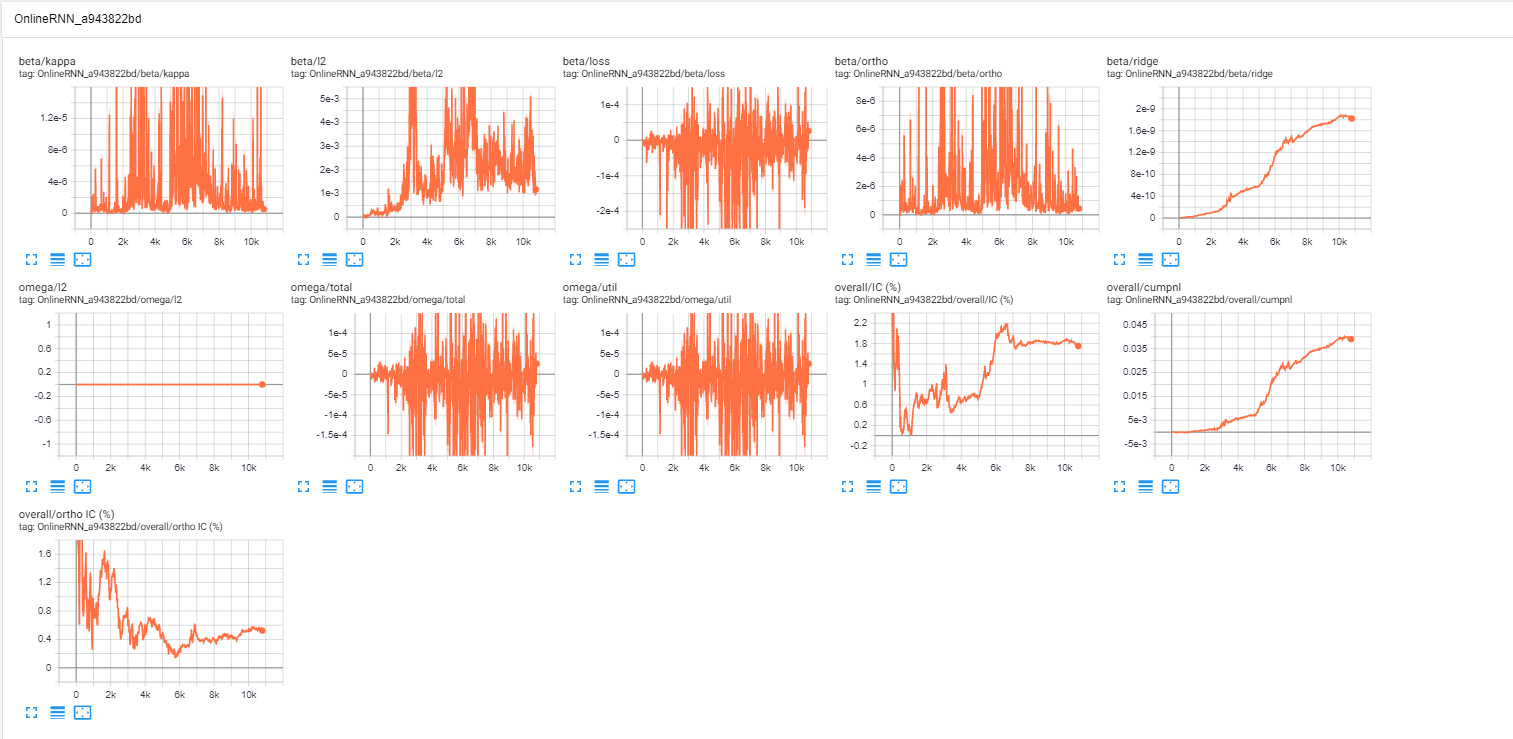

In [ ]:
# online learning
#################

%inline
data = add_vols

technical_features = [
    'true_range_30min',
    'true_range_0D.12h',
    'true_range_2D.12h',
    'true_range_5D',
    'direction_30min',
    'direction_0D.12h',
    'direction_2D.12h',
    'direction_5D',
    #'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
    'ttp_high_adj_0D.12h',
    'ttp_high_adj_2D.12h',
    'ttp_high_adj_5D',
    'ttp_low_adj_0D.12h',
    'ttp_low_adj_2D.12h',
    'ttp_low_adj_5D',
]

disp(mx.tensorboard.start_server())
disp(mx.tensorboard.start(clear=True))

hps.online = mx.HPSet(
    start='20140101',
    end=hps.end,
    features=sorted(
        set([] + [
            'open_unadj_30min',
            'log_open_unadj_30min',
            'lagrtn_adj_30min_resid',
        ] + hps.feature_set.lagging + hps.feature_set.vol +
            hps.feature_set.log_volumes
            #         #+ hps.feature_set.calendar
            #         + hps.feature_set.mkt
            + hps.feature_set.betas
            #          + hps.feature_set.technical
            #          + hps.feature_set.afacs
            + technical_features)),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None,  # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1=None,
    hl_2=None,
    lr=500,
    kappa=2,  # util penalty
    rnn_tv=None,  #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13 * 10,
    # orthogonalize out short term mean reversion
    ortho_features=['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] +
    hps.feature_set.betas,  # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox',
    # stuff related to sid weighting
    use_omega='P',
    omega_lr=10,
    omega_ridge=0,
    omega_shift=0.1,
    pre_winsorize=0.05,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet(
        pre_normalize=True,
        quadratic=True,
        post_normalize=True,
        ema_halflifes=[13 * 5, 13 * 20, 13 * 40],
    ),
    exposures=[
        'valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min'
    ])

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner(hps=hpso, verbose=True).set(memoize=True)
    runner.data = data
    disp(f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2)
    dfo = runner()
    disp(hpso)
    for profile in runner.output_meta:
        main_fig = profile.pop('main_fig')
        exp_fig = profile.pop('exp_fig')
        reg_fig = profile.pop('reg_fig')
        reg_df = profile.pop('regressions')
        if not reg_df.empty:
            reg_df = reg_df.set_index(['returns', 'lag'])
        disp(profile.pop('feature'), profile.pop('transform'), h=3, hr=True)
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp('Regressions', reg_df, h=4)
        # disp( main_fig )
        disp(exp_fig)
        disp(reg_fig)

## online learning iwth the refactored online-runner and minibatching


In [ ]:
# online learning
#################

%inline
data = add_vols
from research.etf_technical import online_runner as reor; reload( reor )

technical_features = [
    'true_range_30min',
    'true_range_0D.12h',
    'true_range_2D.12h',
    'true_range_5D',
    'direction_30min',
    'direction_0D.12h',
    'direction_2D.12h',
    'direction_5D',
    #'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
    'ttp_high_adj_0D.12h',
    'ttp_high_adj_2D.12h',
    'ttp_high_adj_5D',
    'ttp_low_adj_0D.12h',
    'ttp_low_adj_2D.12h',
    'ttp_low_adj_5D',
]

disp(mx.tensorboard.start_server())
disp(mx.tensorboard.start(clear=True))

hps.online = mx.HPSet(
    start='20140101',
    end='20160101',
    batch_size=100,  #for minibatching
    features=sorted(
        set([] + [
            'open_unadj_30min',
            'log_open_unadj_30min',
            'lagrtn_adj_30min_resid',
        ] + hps.feature_set.lagging + hps.feature_set.vol +
            hps.feature_set.log_volumes
            #         #+ hps.feature_set.calendar
            #         + hps.feature_set.mkt
            + hps.feature_set.betas
            #          + hps.feature_set.technical
            #          + hps.feature_set.afacs
            + technical_features)),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None,  # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1=None,
    hl_2=None,
    lr=500,
    kappa=2,  # util penalty
    rnn_tv=None,  #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13 * 10,
    # orthogonalize out short term mean reversion
    ortho_features=['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] +
    hps.feature_set.betas,  # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox',
    # stuff related to sid weighting
    use_omega='P',
    omega_lr=10,
    omega_ridge=0,
    omega_shift=0.1,
    pre_winsorize=None,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet(
        pre_normalize=True,
        quadratic=True,
        post_normalize=True,
        ema_halflifes=[13 * 5, 13 * 20, 13 * 40],
    ),
    exposures=[
        'valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min'
    ])

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = reor.OnlineRunner(hps=hpso, verbose=True).set(memoize=True)
    runner.data = data
    disp(f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2)
    dfo = runner()
    disp(hpso)
    for profile in runner.output_meta:
        main_fig = profile.pop('main_fig')
        exp_fig = profile.pop('exp_fig')
        reg_fig = profile.pop('reg_fig')
        reg_df = profile.pop('regressions')
        if not reg_df.empty:
            reg_df = reg_df.set_index(['returns', 'lag'])
        disp(profile.pop('feature'), profile.pop('transform'), h=3, hr=True)
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp('Regressions', reg_df, h=4)
        # disp( main_fig )
        disp(exp_fig)
        disp(reg_fig)

## Extended timerange

In [ ]:
# online learning
#################

%inline
data = add_vols

technical_features=[
    'true_range_30min', 'true_range_0D.12h', 'true_range_2D.12h', 'true_range_5D',
    'direction_30min', 'direction_0D.12h', 'direction_2D.12h', 'direction_5D',
    #'delta_rtn_30min', 'delta_rtn_0D.12h', 'delta_rtn_2D.12h', 'delta_rtn_5D',
    'ttp_high_adj_0D.12h', 'ttp_high_adj_2D.12h', 'ttp_high_adj_5D',
    'ttp_low_adj_0D.12h', 'ttp_low_adj_2D.12h', 'ttp_low_adj_5D',    
]

disp( mx.tensorboard.start_server() )
disp( mx.tensorboard.start( clear=True ) )
  
hps.online = mx.HPSet(
    start='20140101',
    end=hps.end
    features=sorted( set(
        []
        +['open_unadj_30min', 'log_open_unadj_30min', 'lagrtn_adj_30min_resid',  ] 
        + hps.feature_set.lagging 
        + hps.feature_set.vol 
        + hps.feature_set.log_volumes
#         #+ hps.feature_set.calendar
#         + hps.feature_set.mkt 
        + hps.feature_set.betas
#          + hps.feature_set.technical
#          + hps.feature_set.afacs
        + technical_features
    ) ),
    symbol=None,
    target='leadrtn_adj_30min',
    target_shift=None, # advance the target
    lookahead=2,
    ridge=1e-5,
    hl_1 = None,
    hl_2 = None,
    lr = 500,
    kappa=2, # util penalty
    rnn_tv=None, #{1:1, 2:1, 13:1e-1},
    ortho=2,
    ortho_hl=13*10,
    # orthogonalize out short term mean reversion
    ortho_features = ['valid_30min', 'lagrtn_adj_30min', 'lagrtn_adj_1day'] + hps.feature_set.betas, # + hps.feature_set.statfac,
    weight='valid_30min',
    algo='mbprox', 
    # stuff related to sid weighting
    use_omega='P',
    omega_lr = 10,
    omega_ridge = 0,
    omega_shift = 0.1,
    pre_winsorize=0.01,
    batch_demean=False,
    batch_normalize=False,
    transformer=mx.HPSet( pre_normalize=True, quadratic=True, post_normalize=True, ema_halflifes=[13*5, 13*20, 13*40],  ),
    exposures=['valid_30min', 'lagrtn_adj_30min_1170.ew_beta', 'lagrtn_adj_30min']
)

#--- run a basic configuration ---
if True:
    hpso = hps.online
    runner = OnlineRunner( hps=hpso, verbose=True ).set( memoize=True )
    runner.data = data
    disp( f'Running runner={runner.hash()} with hps={hpso.hash()}', h=2 )
    dfo = runner( )
    disp( hpso )
    for profile in runner.output_meta                    :
        main_fig = profile.pop( 'main_fig' )
        exp_fig = profile.pop( 'exp_fig' )
        reg_fig = profile.pop( 'reg_fig' )
        reg_df = profile.pop( 'regressions' )
        if not reg_df.empty:
            reg_df = reg_df.set_index( ['returns', 'lag'] )
        disp( profile.pop( 'feature' ), profile.pop( 'transform' ), h=3, hr=True )
        # disp( pd.DataFrame( profile, index=['value'] ) )
        disp( 'Regressions', reg_df, h=4 )
        # disp( main_fig )
        disp( exp_fig )
        disp( reg_fig )  

    